In [1]:
import pandas as pd
from Func_extr import *
from Func_viz import *
from Func_analisis  import *         

In [2]:
pixel = 195

mapRep_coper(pixel)

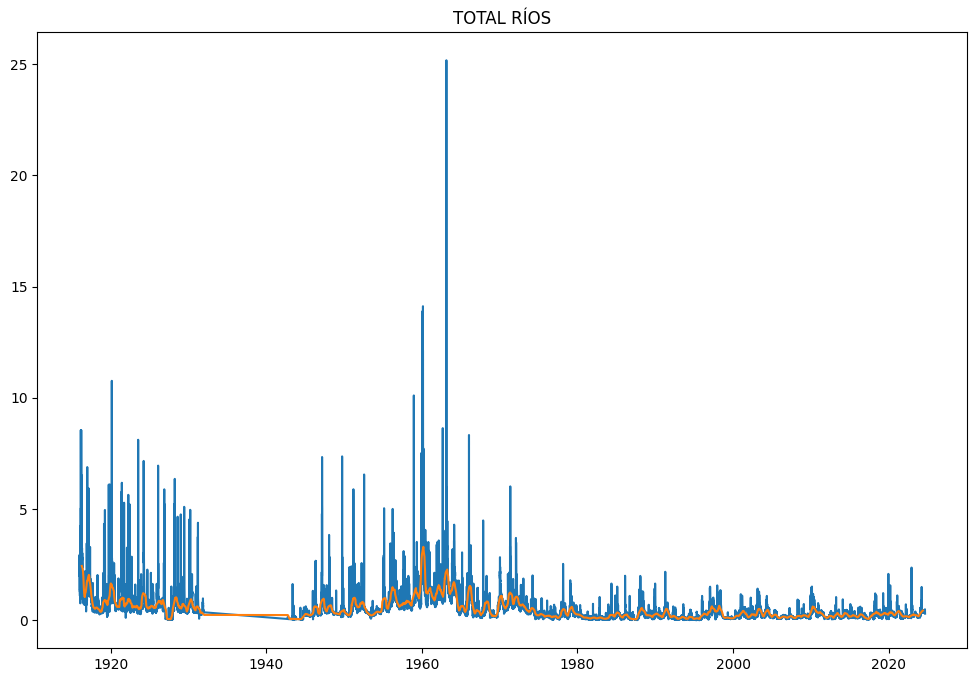

In [3]:
hist_evAgua (pixel, soloAgregados = True)

In [4]:
df_embalses, df_rios, df_c, df_aemet = dataExtract(pixel, x = True)

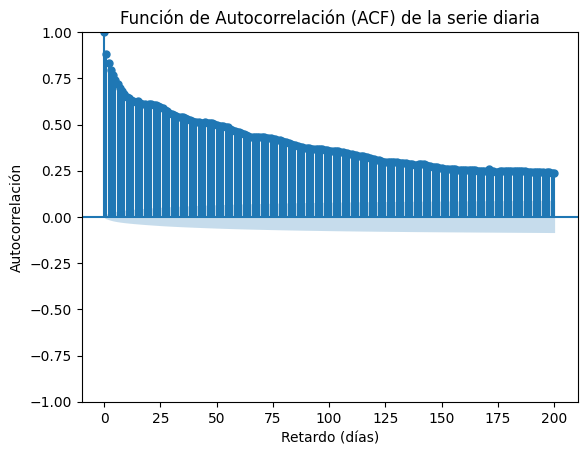

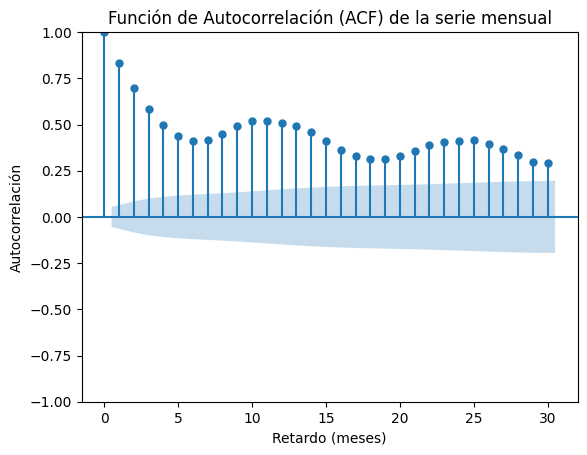

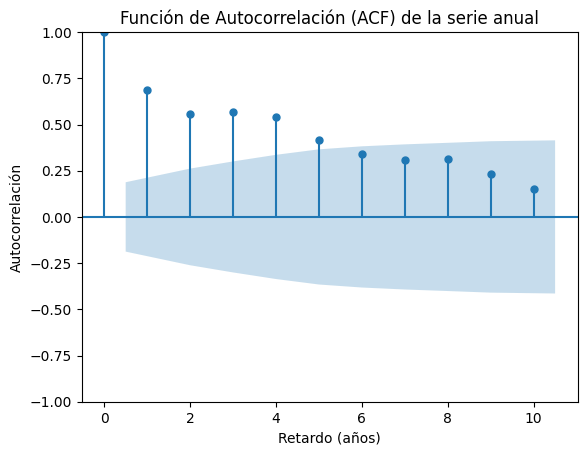

In [5]:
df_rios = df_rios.groupby('date').mean().reset_index()
autocorr_serie (df_rios, ['quantity_hm3'], lags_list = [200,30,10])

In [23]:
df = create_df(pixel)
##Retardos tiempo natural
variables = ['total_precipitation','evaporation','skin_temperature']
df = retardAvg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
df = retardAvg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
df = retardAgg_tNat(df, vars = variables, lags = [1,7,15,20], frec = 'D')
df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,6,8], frec = 'M')
df = retardAgg_tNat(df, vars = variables, lags = [1,2,3,4,5], frec = 'Y')
#retardos tiempo dinámico
df = df.sort_values('date').set_index('date')
#df = retardAvg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
#df = retardAgg_tDin(df, vars = ['total_precipitation','evaporation','tmed','prec'], lags = [1,7,15,20,30,60,100,200,365,730])
df = df.select_dtypes(exclude=['datetime64'])
correlaciones = df.corr()
quantity_hm3_corr = correlaciones['quantity_hm3'].reset_index()
masCorreladasAgua = quantity_hm3_corr[abs(quantity_hm3_corr['quantity_hm3']) >0.1]['index'].to_list()
print(quantity_hm3_corr[(quantity_hm3_corr['quantity_hm3']) >0.2].sort_values('quantity_hm3', ascending = False) )
print(quantity_hm3_corr[(quantity_hm3_corr['quantity_hm3']) <-0.2].sort_values('quantity_hm3', ascending = True) )

                               index  quantity_hm3
8                       quantity_hm3      1.000000
7                         soil_water      0.416303
25   total_precipitation_mean_last6M      0.331962
70    total_precipitation_sum_last6M      0.331254
42   total_precipitation_mean_last4Y      0.324147
87    total_precipitation_sum_last4Y      0.321803
41   total_precipitation_mean_last3Y      0.319717
86    total_precipitation_sum_last3Y      0.316344
24   total_precipitation_mean_last4M      0.314191
69    total_precipitation_sum_last4M      0.312550
40   total_precipitation_mean_last2Y      0.308761
26   total_precipitation_mean_last8M      0.304842
71    total_precipitation_sum_last8M      0.304644
85    total_precipitation_sum_last2Y      0.303870
43   total_precipitation_mean_last5Y      0.296740
88    total_precipitation_sum_last5Y      0.294679
23   total_precipitation_mean_last3M      0.286218
68    total_precipitation_sum_last3M      0.283810
39   total_precipitation_mean_l

### PCA

In [25]:
pca_df = process_pca_for_variables(df = df, variables = variables, frecuencias = ['D', 'M', 'Y'], var_threshold=90)

PCA aplicado para variable 'total_precipitation' y frecuencia 'D'.
Varianza explicada acumulada para los 2 componentes: 90.10247601853966%
PCA aplicado para variable 'total_precipitation' y frecuencia 'M'.
Varianza explicada acumulada para los 3 componentes: 93.80414888968086%
PCA aplicado para variable 'total_precipitation' y frecuencia 'Y'.
Varianza explicada acumulada para los 3 componentes: 92.63388394531339%
PCA aplicado para variable 'evaporation' y frecuencia 'D'.
Varianza explicada acumulada para los 1 componentes: 95.93933345331865%
PCA aplicado para variable 'evaporation' y frecuencia 'M'.
Varianza explicada acumulada para los 2 componentes: 96.55676940827027%
PCA aplicado para variable 'evaporation' y frecuencia 'Y'.
Varianza explicada acumulada para los 3 componentes: 94.71815115463056%
PCA aplicado para variable 'skin_temperature' y frecuencia 'D'.
Varianza explicada acumulada para los 2 componentes: 95.6060205496714%
PCA aplicado para variable 'skin_temperature' y frecuen

In [47]:
df_PCA_quant = pd.merge(df.reset_index()[['date', 'quantity_hm3']],pca_df, on = 'date', how = 'inner').set_index('date')

### Predicciones

#### Regresion lineal

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

# Dividir los datos en entrenamiento y prueba considerando el tiempo
# Usamos datos pasados para entrenar y futuros para prueba
split_point = int(len(X) * 0.8)  # 80% para entrenamiento
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Modelo de Regresión Lineal
linear_model = LinearRegression()

# Entrenar el modelo
linear_model.fit(X_train, y_train)

# Predicciones
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Métricas de evaluación
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"R^2 en entrenamiento: {train_r2:.4f}")
print(f"R^2 en test: {test_r2:.4f}")
print(f"RMSE en entrenamiento: {train_rmse:.4f}")
print(f"RMSE en test: {test_rmse:.4f}")

R^2 en entrenamiento: 0.5605
R^2 en test: -198.8762
RMSE en entrenamiento: 0.4167
RMSE en test: 2.1142


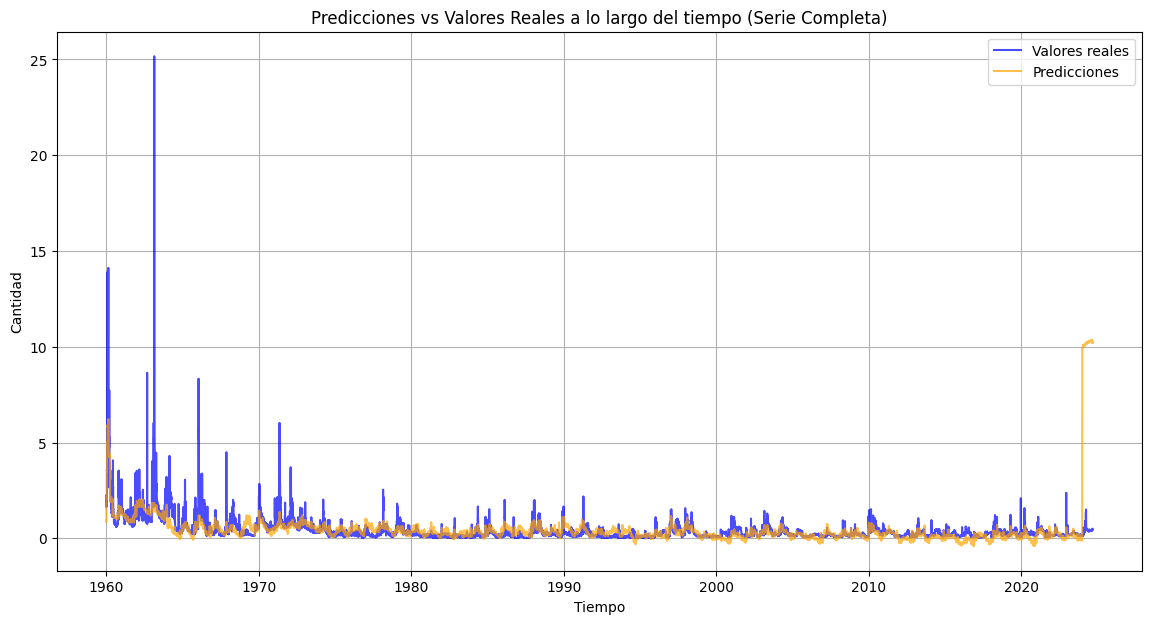

In [65]:
# Concatenar datos de entrenamiento y prueba
y_all = pd.concat([y_train, y_test])
y_pred_all = pd.concat([pd.Series(y_train_pred, index=y_train.index), pd.Series(y_test_pred, index=y_test.index)])

# Asegurarnos de que estén ordenados por tiempo
y_all = y_all.sort_index()
y_pred_all = y_pred_all.sort_index()

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(y_all.index, y_all, label='Valores reales', color='blue', alpha=0.7)
plt.plot(y_pred_all.index, y_pred_all, label='Predicciones', color='orange', alpha=0.7)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.title('Predicciones vs Valores Reales a lo largo del tiempo (Serie Completa)')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
X = df_PCA_quant.drop('quantity_hm3', axis=1)
y = df_PCA_quant['quantity_hm3']

# Añadir una constante para el término independiente (intercepto)
X = sm.add_constant(X)

# Ajustar el modelo usando Statsmodels
model = sm.OLS(y, X)  # Ordinary Least Squares
results = model.fit()

# Mostrar el resumen del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           quantity_hm3   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     1201.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        09:24:08   Log-Likelihood:                -10861.
No. Observations:               23594   AIC:                         2.177e+04
Df Residuals:                   23569   BIC:                         2.197e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

#### Random Forests

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

df_PCA_quant.reset_index(inplace = True)
# Crear variables temporales (índice de tiempo)
df_PCA_quant['time_index'] = np.arange(len(df_PCA_quant))

# Opcional: Agregar términos de tendencia (pueden ser polinómicos)
df_PCA_quant['time_index_squared'] = df_PCA_quant['time_index'] ** 2

# Opcional: Agregar términos estacionales si hay estacionalidad conocida (e.g., meses, días)
df_PCA_quant['month'] = df_PCA_quant['date'].dt.month  # Estacionalidad mensual
df_PCA_quant['year'] = df_PCA_quant['date'].dt.year    # Tendencias anuales
df_PCA_quant = df_PCA_quant.set_index('date')


X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

# Dividir los datos en entrenamiento y prueba considerando el tiempo
# Usamos datos pasados para entrenar y futuros para prueba
split_point = int(len(X) * 0.8)  # 80% para entrenamiento
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]


# Modelo de Random Forest
rf = RandomForestRegressor(
    n_estimators=40,          # Cantida de árboles para capturar patrones
    max_depth=20,            # Límite de profundidad
    min_samples_split=20,       # Divisiones 
    min_samples_leaf=15,        # Permite hojas pequeñas
    random_state=42,           # Reproducibilidad
    bootstrap=True            # 
)

# Entrenar en todos los datos
rf.fit(X_train, y_train)

# Predicciones
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"R^2 en entrenamiento: {train_r2:.4f}")
print(f"R^2 en test: {test_r2:.4f}")




# Importancia de las características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

R^2 en entrenamiento: 0.8432
R^2 en test: -0.1837


##### Validación cruzada Random Forests

In [93]:
from sklearn.model_selection import TimeSeriesSplit

# Preparar los datos como lo has hecho previamente
df_PCA_quant.reset_index(inplace=True)

# Crear variables temporales
df_PCA_quant['time_index'] = np.arange(len(df_PCA_quant))
df_PCA_quant['time_index_squared'] = df_PCA_quant['time_index'] ** 2
df_PCA_quant['month'] = df_PCA_quant['date'].dt.month
df_PCA_quant['year'] = df_PCA_quant['date'].dt.year
df_PCA_quant = df_PCA_quant.set_index('date')

X = df_PCA_quant.drop(['quantity_hm3'], axis=1)
y = df_PCA_quant['quantity_hm3']

# Configurar el modelo de Random Forest
rf = RandomForestRegressor(
    n_estimators=20,          # Cantida de árboles para capturar patrones
    max_depth=5,            # Límite de profundidad
    min_samples_split=50,       # Divisiones 
    min_samples_leaf=50,        # Permite hojas pequeñas
    random_state=42,           # Reproducibilidad
    bootstrap=True            # 
)

# Configurar la validación cruzada temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)  # 5 particiones para la validación cruzada

# Almacenar los resultados
train_r2_scores = []
test_r2_scores = []

# Ejecutar la validación cruzada
for train_index, test_index in tscv.split(X):
    # Dividir los datos en entrenamiento y prueba según la división temporal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entrenar el modelo
    rf.fit(X_train, y_train)
    
    # Hacer predicciones
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # Calcular R^2
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Almacenar los resultados
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Mostrar los resultados de las 5 validaciones cruzadas
print(f"R^2 en entrenamiento (promedio de las 5 particiones): {np.mean(train_r2_scores):.4f}")
print(f"R^2 en test (promedio de las 5 particiones): {np.mean(test_r2_scores):.4f}")


R^2 en entrenamiento (promedio de las 5 particiones): 0.6229
R^2 en test (promedio de las 5 particiones): -0.3732


In [97]:
y_predict_train = pd.Series(y_train_pred)
y_predict_test = pd.Series(y_test_pred)

y_predict = pd.concat([y_predict_train, y_predict_test])
y_predict = y_predict.reset_index()[0]
y = pd.concat([y_train, y_test]).reset_index()
x = pd.concat([X_train, X_test])
df_merge = pd.merge(y,x, on ='date')

df_merge['quantity_hm3_predict'] = y_predict
df_merge.sort_values('date',inplace = True)
df_merge.set_index('date', inplace = True)

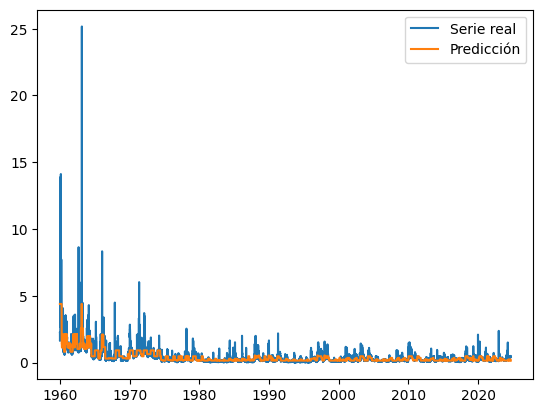

In [98]:

plt.plot(df_merge['quantity_hm3'], label = 'Serie real' )
plt.plot(df_merge['quantity_hm3_predict'] , label = 'Predicción')
plt.legend()
plt.show()

### SVR

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import numpy as np

# Resetear el índice y crear las variables temporales (índice de tiempo)
df_PCA_quant.reset_index(inplace=True)
df_PCA_quant['time_index'] = np.arange(len(df_PCA_quant))

# Opcional: Agregar términos de tendencia (pueden ser polinómicos)
df_PCA_quant['time_index_squared'] = df_PCA_quant['time_index'] ** 2

# Opcional: Agregar términos estacionales si hay estacionalidad conocida (e.g., meses, días)
df_PCA_quant['month'] = df_PCA_quant['date'].dt.month  # Estacionalidad mensual
df_PCA_quant['year'] = df_PCA_quant['date'].dt.year    # Tendencias anuales
df_PCA_quant = df_PCA_quant.set_index('date')

# Variables predictoras y objetivo
X = df_PCA_quant.drop(['quantity_hm3'], axis=1)  # Excluir 'date' si no se usa explícitamente
y = df_PCA_quant['quantity_hm3']

# Dividir los datos en entrenamiento y prueba considerando el tiempo
split_point = int(len(X) * 0.8)  # 80% para entrenamiento
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Modelo SVM (SVR)
svm = SVR(kernel='rbf', C=100, epsilon=0.1)  # Kernel Radial (RBF)

# Entrenar el modelo SVM
svm.fit(X_train, y_train)

# Predicciones
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Evaluar el modelo
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"R^2 en entrenamiento: {train_r2:.4f}")
print(f"R^2 en test: {test_r2:.4f}")


R^2 en entrenamiento: 0.3065
R^2 en test: -216.5708


In [65]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score

# Definir los hiperparámetros a probar en el Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],          # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],         # Profundidad máxima del árbol
    'min_samples_split': [10, 15, 20],       # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [5, 10, 15],         # Mínimo de muestras en cada hoja
    'bootstrap': [True, False]               # Si se usa bootstrap o no
}

# Instanciar el modelo base
rf = RandomForestRegressor(random_state=42)

# Definir el Grid Search con validación cruzada (cv=3)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=make_scorer(r2_score),  # Usar R^2 como métrica de evaluación
    cv=3,                          # Divisiones para validación cruzada
    n_jobs=-1,                     # Usar todos los núcleos disponibles
    verbose=2                      # Imprimir progreso del Grid Search
)

# Realizar el Grid Search
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el mejor modelo en los datos de test
best_rf = grid_search.best_estimator_

train_r2 = r2_score(y_train, best_rf.predict(X_train))
test_r2 = r2_score(y_test, best_rf.predict(X_test))

print(f"R^2 en entrenamiento: {train_r2:.4f}")
print(f"R^2 en test: {test_r2:.4f}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Separación en X e y
X = df.drop('quantity_hm3', axis=1)
y = df['quantity_hm3']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición del espacio de hiperparámetros
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),  # Usar el modelo correcto
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entrenar el modelo
random_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Best parameters:", random_search.best_params_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [59]:
# Variables predictoras y objetivo
X = df.drop('quantity_hm3', axis=1)
y = df['quantity_hm3']

# Modelo de Random Forest
rf_overfit = RandomForestRegressor(
    n_estimators=100,          # Más árboles para capturar patrones
    max_depth=20,            # Sin límite de profundidad
    min_samples_split=10,       # Divisiones hasta lo mínimo
    min_samples_leaf=5,        # Permite hojas pequeñas
    random_state=42,           # Reproducibilidad
    bootstrap=True            # Sin bootstrap para asegurar el ajuste completo
)

# Entrenar en todos los datos
rf_overfit.fit(X, y)

# Importancia de las características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_overfit.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [60]:


# Predicciones del modelo
y_pred = rf_overfit.predict(X)

# Cálculo de métricas
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)
print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

R^2: 0.1573
MSE: 0.1557
RMSE: 0.3946
MAE: 0.2823


In [42]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Configuración del modelo para sobreajustar
xgb_model = XGBRegressor(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.01,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)

# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Predicciones
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Evaluación del modelo
print("Train R^2:", r2_score(y_train, y_train_pred))
print("Test R^2:", r2_score(y_test, y_test_pred))
print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))



KeyboardInterrupt



In [ ]:
importances = xgb_model.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance}")

In [29]:
features = df_mascorr.drop('quantity_hm3',axis = 1)
target = 'quantity_hm3'
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_mascorr), columns=df_mascorr.columns, index=df_mascorr.index)

# Variable dependiente
y = df_scaled[target]
results = []

# Iterar sobre el número de características a usar
for num_features in range(1, len(features) + 1):
    for feature_combination in combinations(features, num_features):
        # Opción 1: Sin constante
        X = df_scaled[list(feature_combination)]
        
        # Ajustar el modelo de regresión lineal sin constante usando statsmodels
        model = sm.OLS(y, X).fit()
        
        # Calcular R^2
        r2 = model.rsquared
        
        # Calcular el número condicional
        number_condition = np.linalg.cond(X)
        
        # Guardar los resultados sin constante
        results.append({
            'Features': feature_combination,
            'R^2': r2,
            'Conditional Number': number_condition,
            'Constant Included': False
        })
        
        # Opción 2: Con constante
        X_const = sm.add_constant(X)  # Añadir constante usando statsmodels
        
        # Ajustar el modelo de regresión lineal con constante
        model_const = sm.OLS(y, X_const).fit()
        
        # Calcular R^2 con constante
        r2_const = model_const.rsquared
        
        # Calcular el número condicional con constante
        number_condition_const = np.linalg.cond(X_const)
        
        # Guardar los resultados con constante
        results.append({
            'Features': feature_combination,
            'R^2': r2_const,
            'Conditional Number': number_condition_const,
            'Constant Included': True
        })

# Convertir los resultados a DataFrame
results_df = pd.DataFrame(results)

KeyboardInterrupt: 

In [32]:
pd.DataFrame(results)['R^2'].max()

0.044311191747510636